In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import math

In [16]:
data = pd.read_csv('data.csv')
data.tail()

,,Area,X,Y,Circ.,Feret,FeretX,FeretY,FeretAngle,MinFeret,AR,Round,Solidity
54,55,0.0940,68.5522,58.2584,1.0000,0.4107,1202.000,1020.0000,123.6901,0.3417,1.0573,0.9458,0.8923
55,56,0.0324,67.6822,58.2403,1.0000,0.2547,1187.000,1021.0000,116.5651,0.1708,1.2356,0.8093,0.9091
56,57,0.0940,66.4962,58.7159,1.0000,0.4337,1164.000,1030.0000,156.8014,0.3242,1.3855,0.7217,0.8529
57,58,0.0097,69.3717,59.2350,1.0000,0.1611,1217.000,1041.0000,45.0000,0.1139,1.4638,0.6831,0.8571
58,60,170.4926,68.9790,51.1706,0.9701,16.9749,1208.561,1047.5867,88.9647,12.8059,1.3254,0.7545,1.0002


In [6]:
# Last row contains the nucleus ellipse parameters
nucleus = data.iloc[-1]
n_X = nucleus['X']
n_Y = nucleus['Y']
n_DiameterMax = nucleus['Feret']  # Major axis
n_DiameterMin = nucleus['MinFeret']  # Minor axis
n_RotAngle = nucleus['FeretAngle']  # Rotation angle in degrees

In [5]:
# Calculate radii
n_RadiusMax = n_DiameterMax / 2
n_RadiusMin = n_DiameterMin / 2

In [7]:
centromeres = data.iloc[:-1].copy()

In [8]:
# Function to calculate distance from a point to the center of the ellipse
def distance_to_center(x, y, center_x, center_y):
    return np.sqrt((x - center_x)**2 + (y - center_y)**2)

In [9]:
def distance_to_edge(x, y, center_x, center_y, a, b, angle_deg):
    # Convert angle to radians
    angle_rad = np.deg2rad(angle_deg)
    
    # Translate point to origin
    x_t = x - center_x
    y_t = y - center_y
    
    # Rotate point to align ellipse with axes
    x_r = x_t * np.cos(-angle_rad) - y_t * np.sin(-angle_rad)
    y_r = x_t * np.sin(-angle_rad) + y_t * np.cos(-angle_rad)
    
    # Calculate angle to the point in the unrotated system
    theta = np.arctan2(y_r, x_r)
    
    # Calculate distance to ellipse edge along the line from center to point
    r = (a * b) / np.sqrt((b * np.cos(theta))**2 + (a * np.sin(theta))**2)
    
    return r


In [11]:
# Calculate distances for each centromere
distances_to_center = []
distances_to_edge = []
distance_ratios = []
distances_to_periphery = []

for idx, centromere in centromeres.iterrows():
    x = centromere['X']
    y = centromere['Y']
    
    # Calculate distance from centromere to nucleus center
    d_center = distance_to_center(x, y, n_X, n_Y)
    distances_to_center.append(d_center)
    
    # Calculate distance from nucleus center to periphery through centromere
    d_edge = distance_to_edge(x, y, n_X, n_Y, n_RadiusMax, n_RadiusMin, n_RotAngle)
    distances_to_edge.append(d_edge)
    
    # Calculate ratio (percentage of distance from center to periphery)
    ratio = d_center / d_edge
    distance_ratios.append(ratio)
    
    # Calculate actual distance from centromere to periphery
    d_periphery = d_edge - d_center if d_center <= d_edge else 0
    distances_to_periphery.append(d_periphery)


In [12]:
# Add results to the dataframe
centromeres['Distance_to_Center'] = distances_to_center
centromeres['Center_to_Edge'] = distances_to_edge
centromeres['Distance_Ratio'] = distance_ratios
centromeres['Distance_to_Periphery'] = distances_to_periphery

# Display first few results
centromeres.head()

,,Area,X,Y,Circ.,Feret,FeretX,FeretY,FeretAngle,MinFeret,AR,Round,Solidity,Distance_to_Center,Center_to_Edge,Distance_Ratio,Distance_to_Periphery
0,1,0.0227,65.9331,44.2198,1.0000,0.2053,1157.0,775.0,123.6901,0.1708,1.0688,0.9356,0.8750,7.588882,8.048418,0.942904,0.459536
1,2,0.0486,68.5440,44.3033,1.0000,0.3067,1201.0,777.0,158.1986,0.2278,1.1275,0.8869,0.8571,6.881063,8.480901,0.811360,1.599838
2,3,0.0195,67.3121,45.1310,1.0000,0.2053,1181.0,791.0,123.6901,0.1139,1.5000,0.6667,1.0000,6.265407,8.295613,0.755268,2.030206
3,4,0.0551,69.4543,45.4492,1.0000,0.3321,1217.0,797.0,149.0362,0.2278,1.2632,0.7917,0.9189,5.741109,8.455004,0.679019,2.713895
4,5,0.1330,68.2684,45.6171,0.9097,0.5094,1195.0,803.0,26.5651,0.4027,1.2765,0.7834,0.8454,5.598778,8.449549,0.662613,2.850771


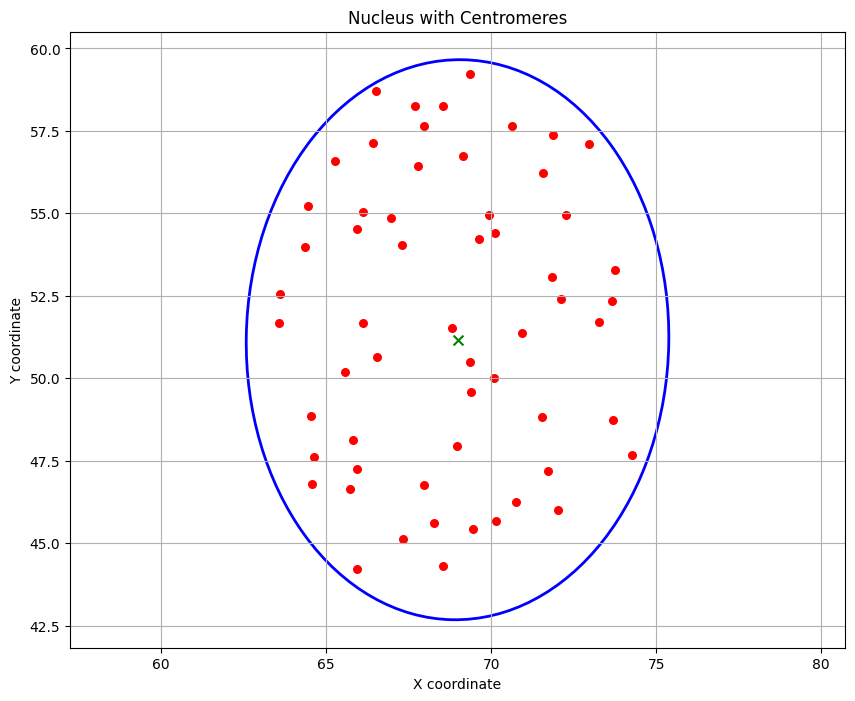

In [13]:
# Plot the results
plt.figure(figsize=(10, 8))

# Create ellipse
ellipse = Ellipse((n_X, n_Y), n_DiameterMax, n_DiameterMin, 
                  angle=n_RotAngle, 
                  fill=False, edgecolor='blue', linewidth=2)
ax = plt.gca()
ax.add_patch(ellipse)

# Plot centromeres
plt.scatter(centromeres['X'], centromeres['Y'], color='red', s=30)
plt.scatter([n_X], [n_Y], color='green', s=50, marker='x')  # Center of nucleus

# Set equal aspect ratio
plt.axis('equal')
plt.grid(True)
plt.title('Nucleus with Centromeres')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')

plt.show()

Distance Statistics:
       Distance_to_Center  Center_to_Edge  Distance_Ratio  \
count           58.000000       58.000000       58.000000   
mean             4.944417        7.588347        0.651270   
std              1.739215        0.718386        0.216471   
min              0.403436        6.410799        0.050563   
25%              3.632812        6.942546        0.516492   
50%              5.259806        7.701315        0.675023   
75%              6.162931        8.306163        0.809469   
max              8.073956        8.486926        0.973631   

       Distance_to_Periphery  
count              58.000000  
mean                2.643929  
std                 1.683184  
min                 0.215132  
25%                 1.413304  
50%                 2.483415  
75%                 3.518393  
max                 7.575500  


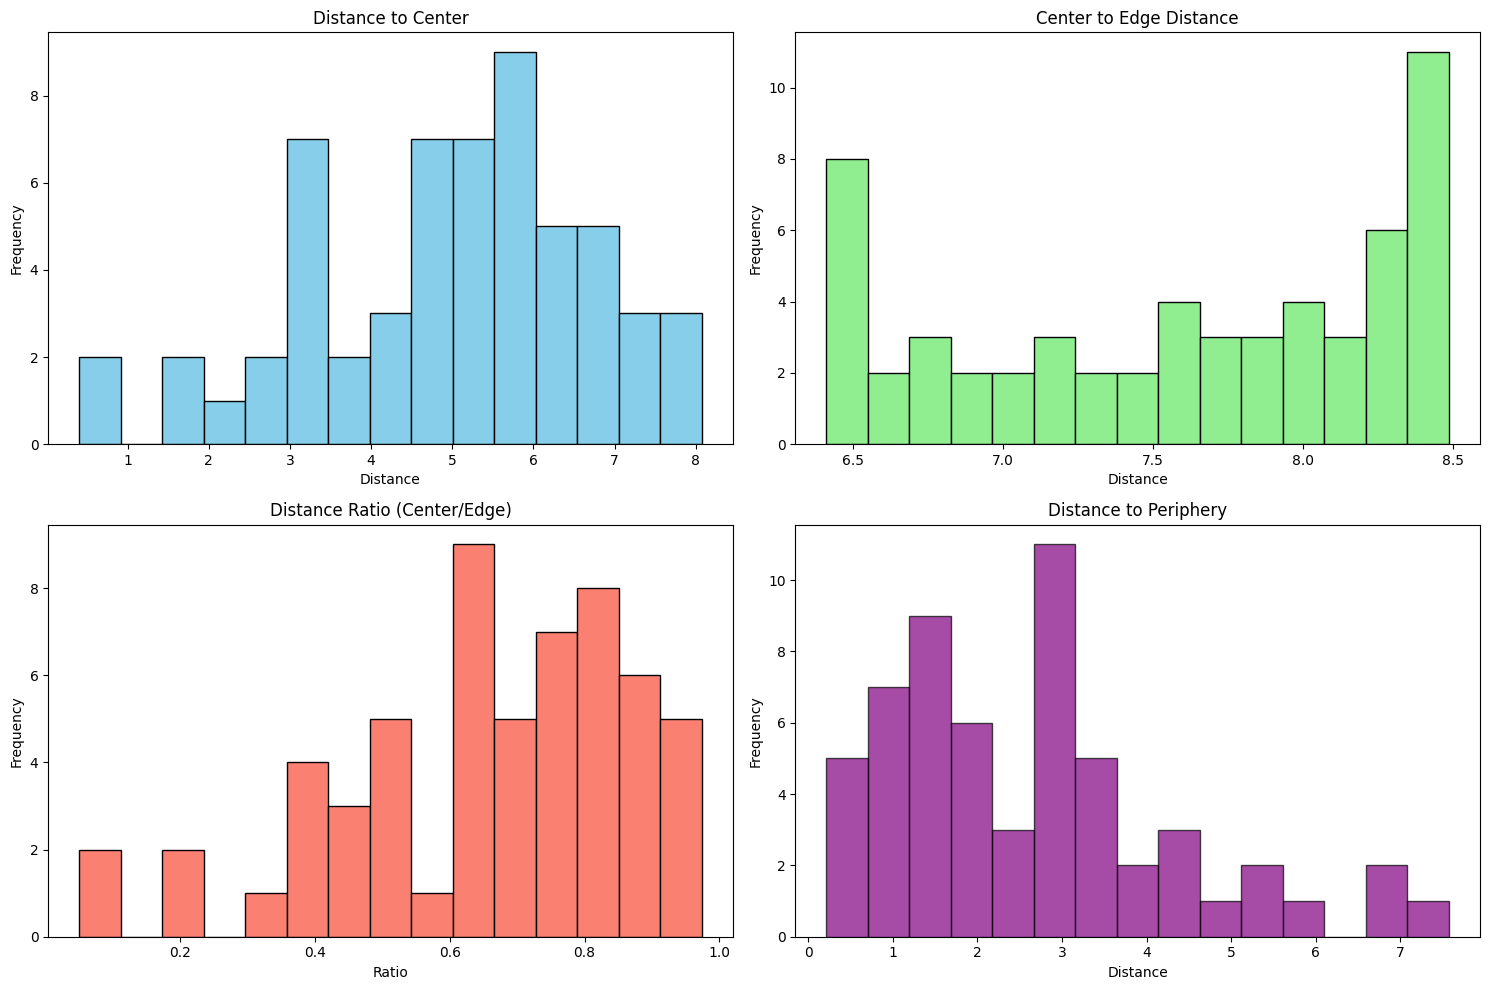

In [14]:
# Statistical summary of distances
print("Distance Statistics:")
print(centromeres[['Distance_to_Center', 'Center_to_Edge', 
                  'Distance_Ratio', 'Distance_to_Periphery']].describe())

# Create histograms
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(centromeres['Distance_to_Center'], bins=15, color='skyblue', edgecolor='black')
plt.title('Distance to Center')
plt.xlabel('Distance')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(centromeres['Center_to_Edge'], bins=15, color='lightgreen', edgecolor='black')
plt.title('Center to Edge Distance')
plt.xlabel('Distance')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(centromeres['Distance_Ratio'], bins=15, color='salmon', edgecolor='black')
plt.title('Distance Ratio (Center/Edge)')
plt.xlabel('Ratio')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(centromeres['Distance_to_Periphery'], bins=15, color='purple', edgecolor='black', alpha=0.7)
plt.title('Distance to Periphery')
plt.xlabel('Distance')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [15]:
# Save results to CSV
result_df = pd.concat([centromeres, data.iloc[[-1]]], ignore_index=False)
result_df.to_csv('claude_centromere_distance_analysis.csv', index=False)